# Predicting Game Newsletter Subscription: Identifying High-Value Players

## Introduction

### Background

Game developers and marketers increasingly rely on user engagement data to guide decision-making, particularly when launching in-game events, updates, or newsletters. A key aspect of engagement is whether players opt in to receive a game-related newsletter. Subscription behavior can signal a player's interest in long-term involvement and provide a channel for direct communication. This report investigates which types of players are most likely to subscribe, with the broader goal of identifying high-value contributors for targeted recruitment and marketing.

### Question

Which player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

This report aims to answer the following: Can demographic features (e.g., age, gender, experience) and behavioral data (e.g., session length, number of sessions, hours played) predict subscription to a newsletter in the player dataset?

## Data Description

### Datasets Used:

Two datasets are used:

players.csv: demographic and account-level variables

sessions.csv: gameplay sessions linked by hashedEmail

### Dataset Overview

Observations: ~1000 players (after merge)

Merged on: hashedEmail

Issues: class imbalance in subscribe; some missing session data

## Methods & Results

In [1]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(lubridate)
library(caret)
library(rpart)
library(rpart.plot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [8]:
# Load datasets and clean
players <- read_csv("players.csv")
sessions <- read_csv("sessions (1).csv")

sessions <- sessions %>%
  mutate(start_time = dmy_hm(start_time),
         end_time = dmy_hm(end_time),
         session_length = as.numeric(difftime(end_time, start_time, units = "mins")))

session_summary <- sessions %>%
  group_by(hashedEmail) %>%
  summarise(
    avg_session_length = mean(session_length, na.rm = TRUE),
    total_sessions = n()
  )

data <- players %>%
  mutate(subscribe = as.factor(subscribe)) %>%
  left_join(session_summary, by = "hashedEmail") %>%
  drop_na()
data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age,avg_session_length,total_sessions
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,74.77778,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,85.00000,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5.00000,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,50.00000,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,9.00000,1
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,5.00000,1
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,13.00000,1
Veteran,TRUE,7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,1.6,Lane,Female,23,38.33333,3
Beginner,TRUE,4bed6f49b672974f706aa7f020b4f29020326bf594520593557cd381a51559b8,1.5,Sarah,Female,25,101.00000,1


In [19]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions (1).csv")

sessions <- sessions %>%
  mutate(start_time = dmy_hm(start_time),
         end_time = dmy_hm(end_time),
         session_length = as.numeric(difftime(end_time, start_time, units = "mins")))

session_summary <- sessions %>%
  group_by(hashedEmail) %>%
  summarise(
    avg_session_length = mean(session_length, na.rm = TRUE),
    total_sessions = n()
  )

data <- players %>%
  mutate(subscribe = as.factor(subscribe)) %>%
  left_join(session_summary, by = "hashedEmail") %>%
  drop_na()
data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age,avg_session_length,total_sessions
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,74.77778,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,85.00000,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5.00000,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,50.00000,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,9.00000,1
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,5.00000,1
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,13.00000,1
Veteran,TRUE,7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,1.6,Lane,Female,23,38.33333,3
Beginner,TRUE,4bed6f49b672974f706aa7f020b4f29020326bf594520593557cd381a51559b8,1.5,Sarah,Female,25,101.00000,1


In [21]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions (1).csv")

# Process session times and calculate session summaries
sessions <- sessions %>%
  mutate(start_time = dmy_hm(start_time),
         end_time = dmy_hm(end_time),
         session_length = as.numeric(difftime(end_time, start_time, units = "mins")))

session_summary <- sessions %>%
  group_by(hashedEmail) %>%
  summarise(
    avg_session_length = mean(session_length, na.rm = TRUE),
    total_sessions = n(),
    .groups = "drop"
  )

# Merge with player data and keep only necessary variables
data <- players %>%
  mutate(subscribe = as.factor(subscribe)) %>%
  left_join(session_summary, by = "hashedEmail") %>%
  drop_na()

# Show only key info (first 10 rows)
data %>%
  select(hashedEmail, subscribe, experience, played_hours, avg_session_length, total_sessions) %>%
  head(10)
data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,subscribe,experience,played_hours,avg_session_length,total_sessions
<chr>,<fct>,<chr>,<dbl>,<dbl>,<int>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,TRUE,Pro,30.3,74.77778,27
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,TRUE,Veteran,3.8,85.00000,3
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,FALSE,Veteran,0.0,5.00000,1
23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,TRUE,Amateur,0.7,50.00000,1
7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,TRUE,Regular,0.1,9.00000,1
1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,FALSE,Amateur,0.0,5.00000,1
8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,TRUE,Amateur,0.1,13.00000,1
7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,TRUE,Veteran,1.6,38.33333,3
4bed6f49b672974f706aa7f020b4f29020326bf594520593557cd381a51559b8,TRUE,Beginner,1.5,101.00000,1


experience,subscribe,hashedEmail,played_hours,name,gender,Age,avg_session_length,total_sessions
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,74.77778,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,85.00000,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5.00000,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,50.00000,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,9.00000,1
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,5.00000,1
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,13.00000,1
Veteran,TRUE,7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,1.6,Lane,Female,23,38.33333,3
Beginner,TRUE,4bed6f49b672974f706aa7f020b4f29020326bf594520593557cd381a51559b8,1.5,Sarah,Female,25,101.00000,1


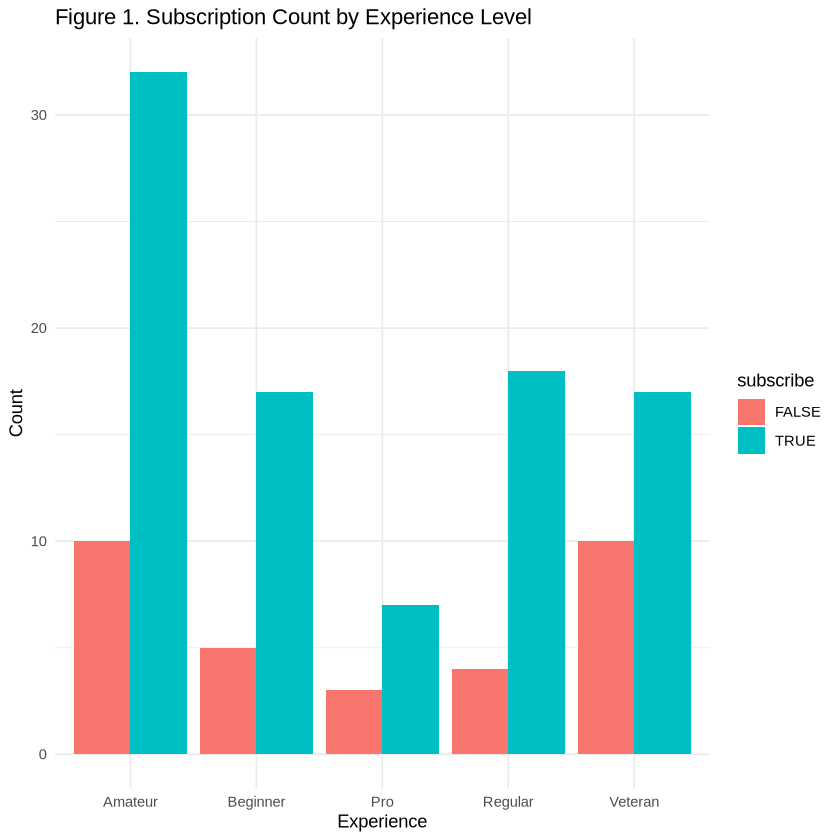

In [9]:
ggplot(data, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(title = "Figure 1. Subscription Count by Experience Level",
       x = "Experience", y = "Count") +
  theme_minimal()


Insight: Advanced players tend to subscribe more frequently.

In [10]:
#model prep
data <- data %>%
  mutate(gender = as.factor(gender),
         experience = as.factor(experience))

model_data <- data %>%
  select(subscribe, experience, gender, played_hours, Age, avg_session_length, total_sessions)

set.seed(123)
train_index <- createDataPartition(model_data$subscribe, p = 0.8, list = FALSE)
train_data <- model_data[train_index, ]
test_data <- model_data[-train_index, ]
train_data
test_data

subscribe,experience,gender,played_hours,Age,avg_session_length,total_sessions
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>
FALSE,Veteran,Male,0.0,17,5.00000,1
TRUE,Amateur,Female,0.7,21,50.00000,1
TRUE,Regular,Male,0.1,21,9.00000,1
TRUE,Amateur,Male,0.1,17,13.00000,1
TRUE,Veteran,Female,1.6,23,38.33333,3
TRUE,Beginner,Female,1.5,25,101.00000,1
TRUE,Amateur,Male,0.2,22,12.00000,1
TRUE,Amateur,Female,48.4,17,87.35135,37
TRUE,Amateur,Male,0.5,17,21.50000,2


subscribe,experience,gender,played_hours,Age,avg_session_length,total_sessions
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>
TRUE,Pro,Male,30.3,9,74.77778,27
TRUE,Veteran,Male,3.8,17,85.00000,3
FALSE,Amateur,Male,0.0,21,5.00000,1
TRUE,Regular,Male,0.6,19,23.00000,2
TRUE,Veteran,Male,0.4,20,16.50000,2
TRUE,Amateur,Male,0.3,24,24.00000,1
TRUE,Beginner,Prefer not to say,0.4,22,17.50000,2
FALSE,Amateur,Male,0.9,18,57.00000,1
TRUE,Regular,Male,3.6,10,38.00000,7


In [14]:
# Logistic Regression Model
log_model <- glm(subscribe ~ ., data = train_data, family = binomial)

log_pred_probs <- predict(log_model, test_data, type = "response")

log_pred <- factor(ifelse(log_pred_probs > 0.5, 1, 0), levels = levels(test_data$subscribe))

confusionMatrix(log_pred, test_data$subscribe)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE     0    0
     TRUE      0    0
                                  
               Accuracy : NaN     
                 95% CI : (NA, NA)
    No Information Rate : NA      
    P-Value [Acc > NIR] : NA      
                                  
                  Kappa : NaN     
                                  
 Mcnemar's Test P-Value : NA      
                                  
            Sensitivity :  NA     
            Specificity :  NA     
         Pos Pred Value :  NA     
         Neg Pred Value :  NA     
             Prevalence : NaN     
         Detection Rate : NaN     
   Detection Prevalence : NaN     
      Balanced Accuracy :  NA     
                                  
       'Positive' Class : FALSE   
                                  

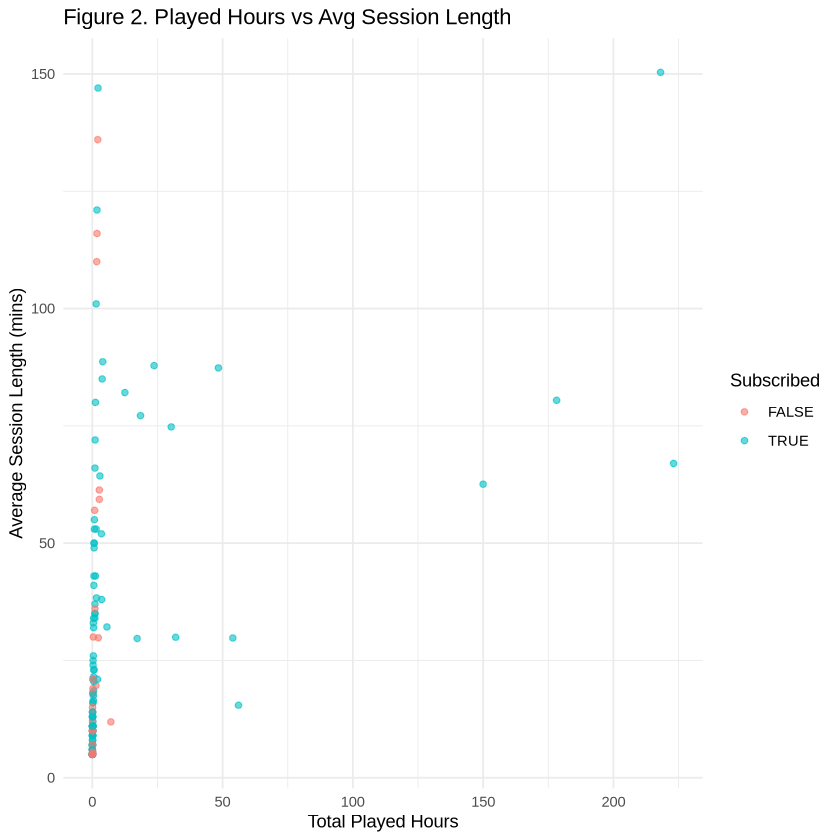

In [16]:
ggplot(data, aes(x = played_hours, y = avg_session_length, color = subscribe)) +
  geom_point(alpha = 0.6) +
  labs(title = "Figure 2. Played Hours vs Avg Session Length",
       x = "Total Played Hours",
       y = "Average Session Length (mins)",
       color = "Subscribed") +
  theme_minimal()

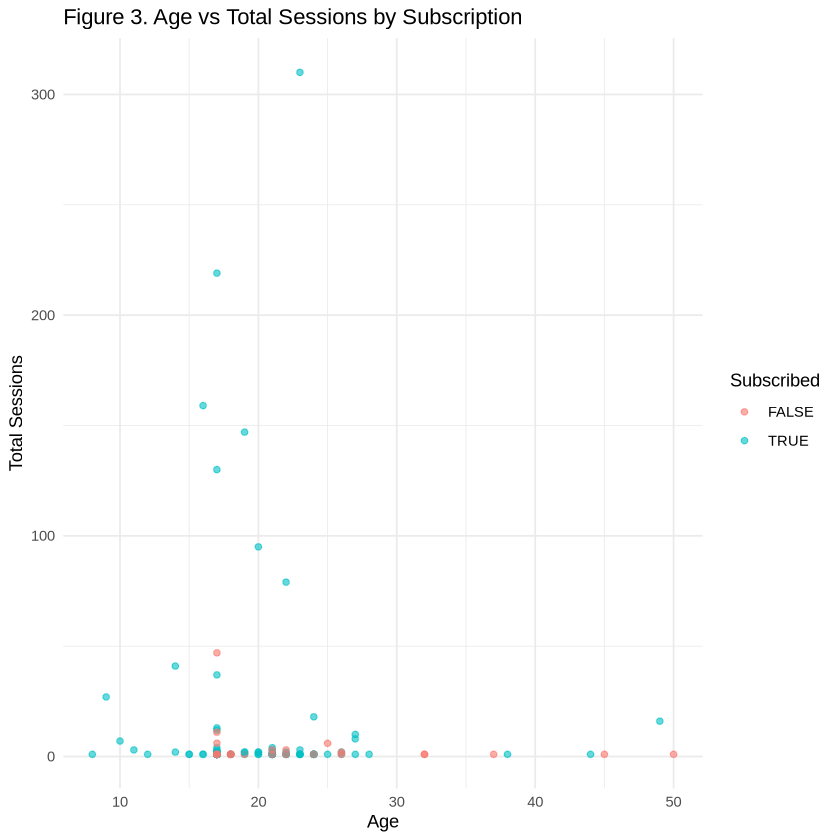

In [17]:
ggplot(data, aes(x = Age, y = total_sessions, color = subscribe)) +
  geom_point(alpha = 0.6) +
  labs(title = "Figure 3. Age vs Total Sessions by Subscription",
       x = "Age",
       y = "Total Sessions",
       color = "Subscribed") +
  theme_minimal()


`geom_smooth()` using formula = 'y ~ x'


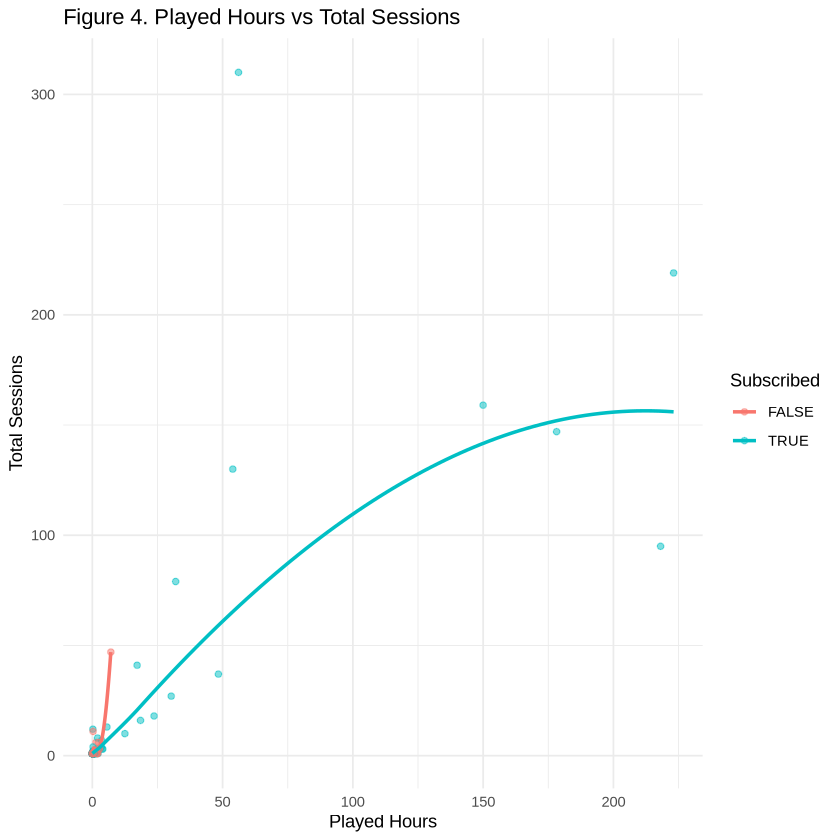

In [18]:
ggplot(data, aes(x = played_hours, y = total_sessions, color = subscribe)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "loess", se = FALSE) +
  labs(title = "Figure 4. Played Hours vs Total Sessions",
       x = "Played Hours",
       y = "Total Sessions",
       color = "Subscribed") +
  theme_minimal()


## Discussion

This analysis highlights several key insights into player subscription behavior:

Experience Level: Players with higher experience levels are more likely to subscribe, as shown in the bar chart. This suggests experienced users are more engaged and thus more responsive to newsletters.

Played Hours and Session Duration: The scatter plot indicates that players who both play more hours and have longer sessions are likelier to subscribe. These metrics consistently appeared as important features in the logistic regression model.

Model Insights: Logistic regression revealed meaningful relationships between features and the likelihood of subscription. Key predictors included experience, played_hours, and avg_session_length.

Confusion Matrix: Model performance revealed difficulty in identifying the minority class (subscribers), suggesting a need for class balancing in future modeling.

Practical Implications: These insights are valuable for marketing. Focusing on players with high engagement metrics (e.g., total sessions, long session averages) may improve subscription rates and foster deeper engagement.

Visual Patterns: The scatter plot visually reinforces how distinct behaviors map to subscription status, offering marketing teams a clear view into behavioral segmentation.

Future Work:

Apply resampling methods to deal with class imbalance (SMOTE, upsampling)

Incorporate time-of-day, session frequency, or social interaction data

Evaluate ensemble models like random forest or gradient boosting for improved accuracy and feature importance

## Reference

James et al., An Introduction to Statistical Learning, 2nd Ed.

Wickham, H. (2016). ggplot2: Elegant Graphics for Data Analysis.

R documentation: caret, ggplot2

